# Table Extraction

In this notebook, we will extract tables from pdfs and save them as csv files. We will do this in two steps - first, extract tables as images, and then convert images to csv's.

In [1]:
import logging
import pathlib
from tqdm import tqdm

import numpy as np

from pdf2image import convert_from_path, pdfinfo_from_path
from mmdet.apis import init_detector, inference_detector, show_result_pyplot

from src.components import config
from src.components.preprocessing import PDFTableExtractor

logger = logging.getLogger()
logger.setLevel(logging.ERROR)

In [2]:
# set file paths
DATA_FOLDER = pathlib.Path('../../data').resolve()
PDF_FOLDER = DATA_FOLDER / "pdfs"
EXTRACTION_FOLDER = DATA_FOLDER / "extraction"
CONFIG_FOLDER = pathlib.Path('./config').resolve()
CHECKPOINT_FOLDER = pathlib.Path('../../models').resolve()

In [3]:
# table extractor args
PDFTableExtractor_kwargs = {
    "batch_size": -1,
    "cscdtabnet_config": CONFIG_FOLDER / "cascade_mask_rcnn_hrnetv2p_w32_20e_v2.py",  # if original is used then open-mmlab/mmdetection#4397
    "cscdtabnet_ckpt": CHECKPOINT_FOLDER / "icdar_19b2_v2.pth",  # _v2 loads fine but otherwise doesnt
    "bbox_thres": .85,
    "dpi": 200
}

# init extractor
table_extractor = PDFTableExtractor(**PDFTableExtractor_kwargs)

Downloading...
From: https://drive.google.com/uc?id=1dmYzZP8eF6_EkkJagN6NJ9A7ReOy_ICY
To: /home/kachau/Documents/diffbranch/aicoe-osc-demo/models/icdar_19b2_v2.pth
100%|█████████████████████████████████████████████████████████████████| 664M/664M [00:17<00:00, 37.1MB/s]
/home/kachau/.local/share/virtualenvs/aicoe-osc-demo-QlLYP2u9/lib/python3.8/site-packages/mmdet/models/builder.py:51: UserWarning: train_cfg and test_cfg is deprecated, please specify them in model
  warnings.warn(
/home/kachau/.local/share/virtualenvs/aicoe-osc-demo-QlLYP2u9/lib/python3.8/site-packages/mmdet/core/anchor/builder.py:16: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  warnings.warn(
/home/kachau/.local/share/virtualenvs/aicoe-osc-demo-QlLYP2u9/lib/python3.8/site-packages/mmcv/utils/misc.py:323: UserWarning: "out_size" is deprecated in `RoIAlign.__init__`, please use "output_size" instead
  warnings.warn(
/home/kachau/.local/share/virtualenvs/aicoe-o

Use load_from_local loader


### Extract tables from a single pdf file
Table Extraction happens in two stages:
1. **Infer Bounding Box:** Convert a pdf into image and use an object detection model for table recognition. The model is called CascadeTabNet. The output of this stage is the coordinates of tables.

2. **Extract tables:** from PDFs using Tabula. The coordinates are passed to tabula for analyzing that area of page.

In [4]:
# sample data
pdf_path = DATA_FOLDER / "pdfs/ESG/sustainability-report-2019.pdf"
pdf_path

PosixPath('/home/kachau/Documents/diffbranch/aicoe-osc-demo/data/pdfs/ESG/sustainability-report-2019.pdf')

### 1. Infer Bounding Box

In [5]:
# convert from pdf to sequence of images
images = convert_from_path(
    pdf_path,
    first_page=1,
    last_page=20,
    use_pdftocairo=True,
    dpi=PDFTableExtractor_kwargs["dpi"],
)

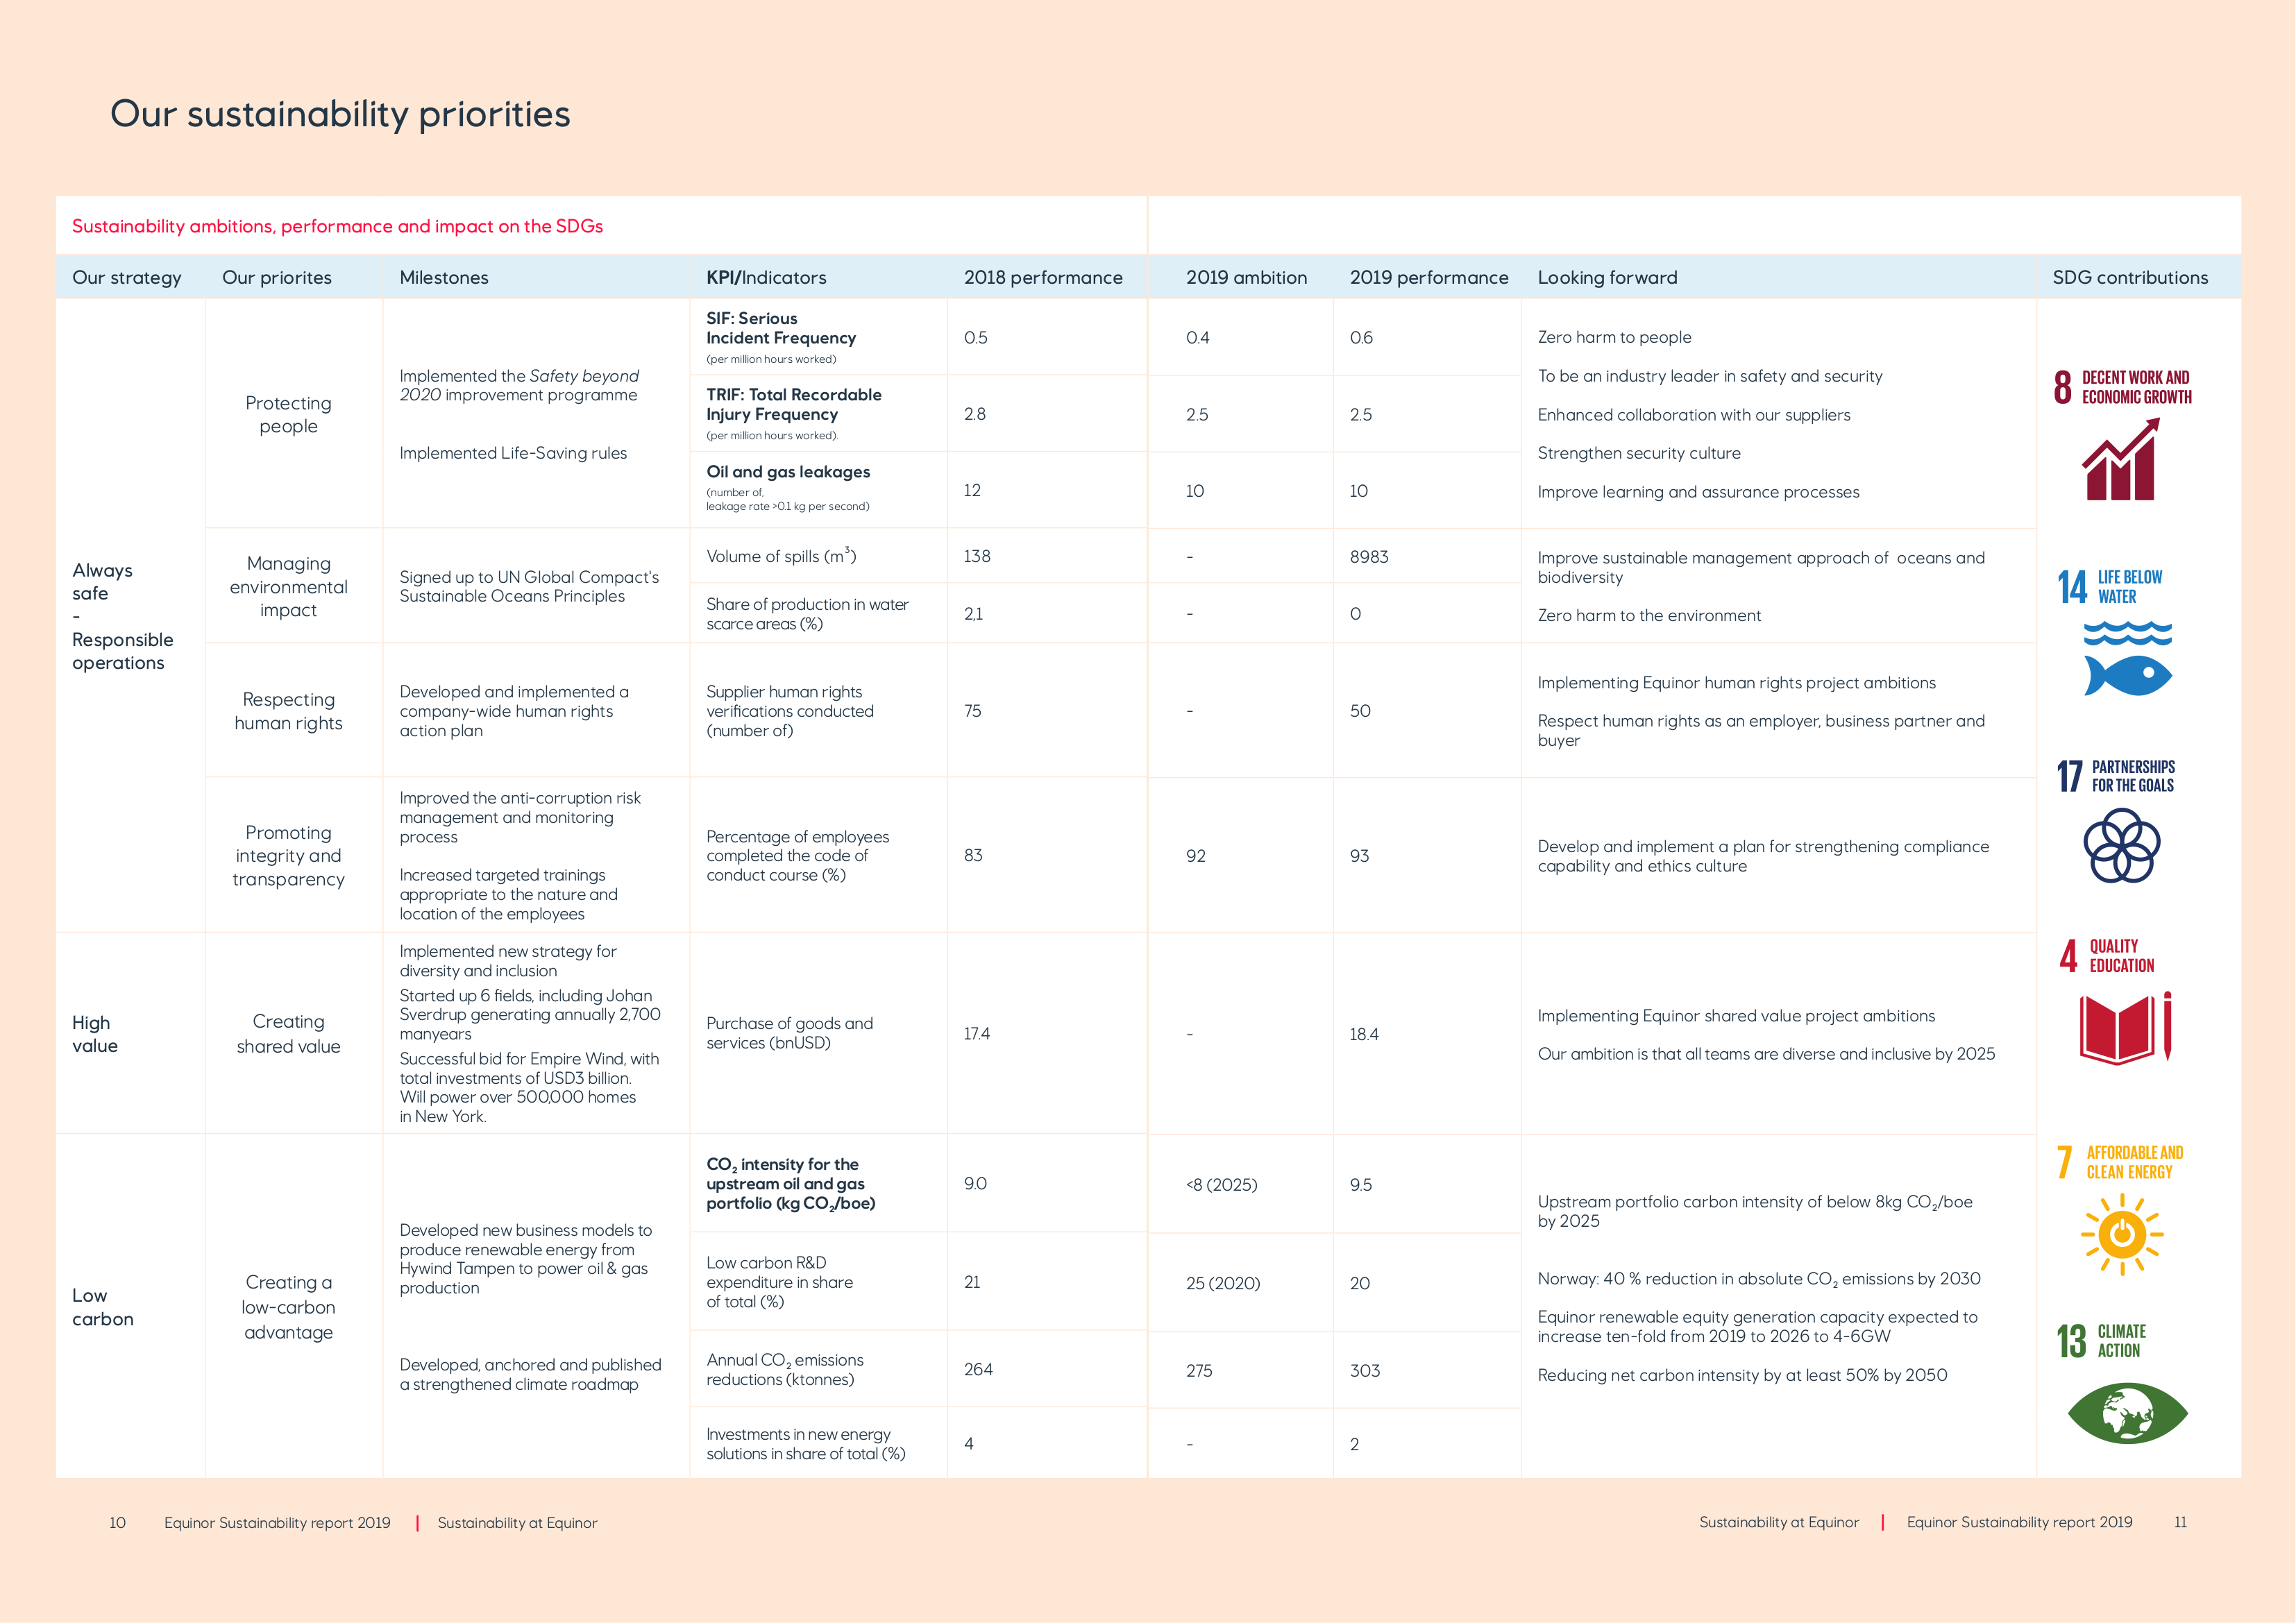

In [6]:
# view a single page (that we know contains a table)
page_num = 5
images[page_num]

In [7]:
# get bounding box coordinates for tables
temp = inference_detector(table_extractor.model, np.array(images[page_num]))
# temp = inference_detector(table_extractor.model, './demo.png')
print ("Coordinates and probabilities of bordered tables\n", (temp[0][0]))
print ("Coordinates and probabilities of borderless tables\n", (temp[0][2]))

/home/kachau/.local/share/virtualenvs/aicoe-osc-demo-QlLYP2u9/lib/python3.8/site-packages/mmdet/datasets/utils.py:65: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(
/home/kachau/.local/share/virtualenvs/aicoe-osc-demo-QlLYP2u9/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/home/kachau/.local/share/virtualenvs/aicoe-osc-demo-QlLYP2u9/lib/python3.8/site-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/home/kachau/.local/share/virtualenvs/aicoe

Coordinates and probabilities of bordered tables
 [[1.0216286e+02 3.5886221e+02 3.2409749e+03 2.1675020e+03 1.7206641e-01]]
Coordinates and probabilities of borderless tables
 [[1.0286604e+02 3.5520404e+02 3.2359028e+03 2.1641687e+03 9.3002194e-01]]


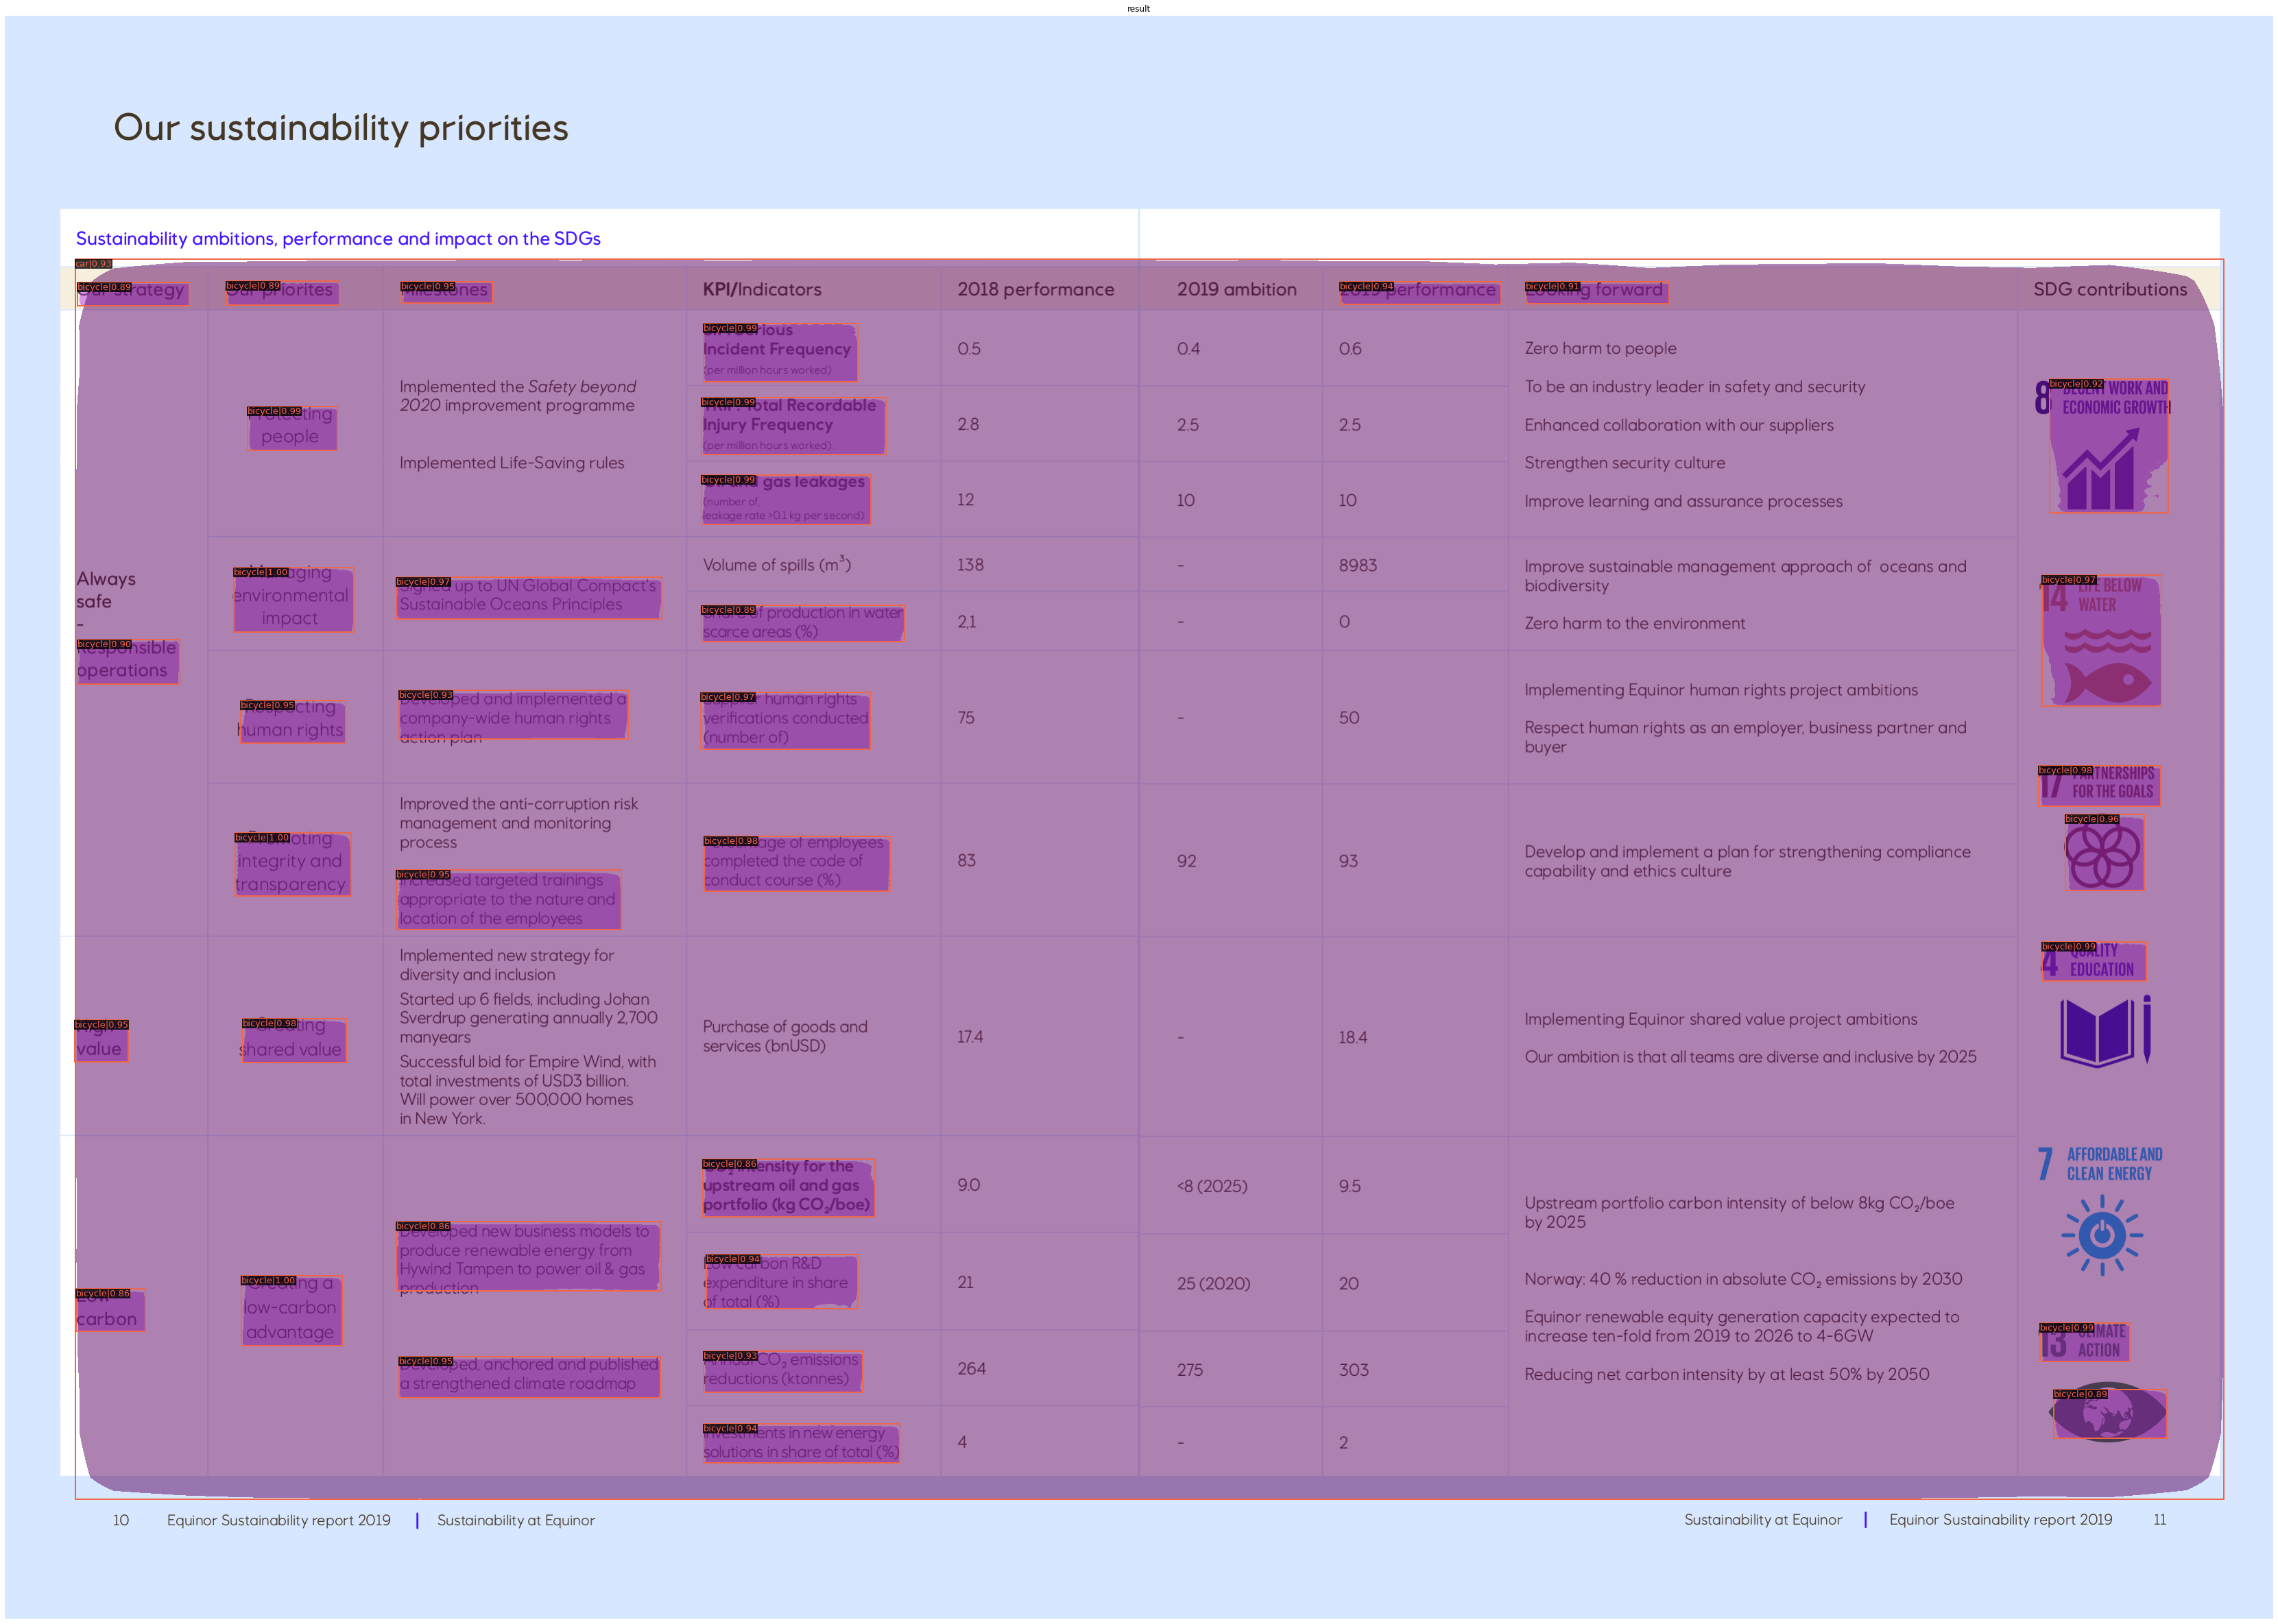

In [8]:
# visualize the tables
show_result_pyplot(
    model=table_extractor.model,
    img=np.array(images[page_num]), 
    result=temp,
    score_thr=PDFTableExtractor_kwargs["bbox_thres"],
)

These steps are encapsulated in a single function in PDFTableExtractor, `infer_bbox()`

In [9]:
# Infer bbox for each page
table_coords = table_extractor.infer_bbox(pdf_path)

Inferring tables for page 1-34:   0%|                                             | 0/33 [00:00<?, ?it/s]/home/kachau/.local/share/virtualenvs/aicoe-osc-demo-QlLYP2u9/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/home/kachau/.local/share/virtualenvs/aicoe-osc-demo-QlLYP2u9/lib/python3.8/site-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/home/kachau/.local/share/virtualenvs/aicoe-osc-demo-QlLYP2u9/lib/python3.8/site-packages/mmdet/core/anchor/anchor_generator.py:360: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  warnings.war

### 2. Extract Table using Tabula

`extract_table()` extracts tables using Tabula and saves them as csv in the extraction folder

In [10]:
# convert from image to table
tables, tables_meta = table_extractor.extract_table(pdf_path, table_coords, EXTRACTION_FOLDER)

Extracting and saving tables: 100%|███████████████████████████████████| 14/14 [00:00<00:00, 97541.95it/s]


In [11]:
# view the extracted table from the sample page
tables[page_num+1][0]

,0,1,2,3,4,5,6,7,8
0,Our strategy,Our priorites,Milestones KPI/Indicators 2018 performance,2019 ambition,2019 performance,NaN,Looking forward,NaN,SDG contributions
1,NaN,NaN,SIF: Serious,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,Incident Frequency 0.5,0.4,0.6,NaN,Zero harm to people,NaN,NaN
3,NaN,NaN,(per million hours worked),NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,Implemented the Safety beyond,NaN,NaN,NaN,To be an industry leader in safety and security,NaN,NaN
5,NaN,Protecting,2020 improvement programme TRIF: Total Recordable,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,Injury Frequency 2.8,2.5,2.5,NaN,Enhanced collaboration with our suppliers,NaN,NaN
7,NaN,people,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,(per million hours worked).,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,Implemented Life-Saving rules,NaN,NaN,NaN,Strengthen security culture,NaN,NaN


In [12]:
# view all result files
!ls $EXTRACTION_FOLDER

esg_TEXT_dataset.csv
sustainability-report-2019.json
sustainability-report-2019_page13_1.csv
sustainability-report-2019_page16_1.csv
sustainability-report-2019_page22_1.csv
sustainability-report-2019_page24_1.csv
sustainability-report-2019_page27_1.csv
sustainability-report-2019_page28_1.csv
sustainability-report-2019_page29_1.csv
sustainability-report-2019_page30_1.csv
sustainability-report-2019_page30_2.csv
sustainability-report-2019_page31_1.csv
sustainability-report-2019_page4_1.csv
sustainability-report-2019_page6_1.csv
sustainability-report-2019_page7_1.csv
sustainability-report-2019_page9_1.csv


## Automate these processes using run_folder() function

We extract all tables from pdfs in the `data/pdfs` folder. First, let's delete all files in the extraction folder. In the pdfs folder, we have both `2015_BASF_Report.pdf` and `cez-annual-report-2018.pdf`.

In [13]:
!rm -rf $EXTRACTION_FOLDER/*

In [14]:
!ls $EXTRACTION_FOLDER

This whole process will take approximately 15-20min due to 

In [15]:
table_extractor.run_folder(PDF_FOLDER, EXTRACTION_FOLDER)

In [16]:
!ls $EXTRACTION_FOLDER

Notice that there is a `table_meta.json` which contains the corresponding table csv files for each page of each pdf file.

# Conclusion

In this notebook, we extracted the tables from the pdf, and saved them as csv files. Next, we will curate these extracted tables.